In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from enum import Enum
from functools import partial
from typing import Optional
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

In [2]:
from IPython.display import clear_output
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [3]:
USE_CUDA = torch.cuda.is_available()

print("cuda is available:", USE_CUDA)

cuda is available: True


# Data

In [4]:
import numpy as np
from typing import Tuple

import torchvision


def load_MNIST() -> Tuple[np.ndarray, np.ndarray]:
    train_data = torchvision.datasets.MNIST(root="./", train=True, download=True)
    test_data = torchvision.datasets.MNIST(root="./", train=False, download=True)
    train_data, test_data = train_data.data.numpy(), test_data.data.numpy()
    axis_index = len(train_data.shape)
    train_data = np.expand_dims(train_data, axis=axis_index)
    test_data = np.expand_dims(test_data, axis=axis_index)

    return train_data, test_data


def load_CIFAR10() -> Tuple[np.ndarray, np.ndarray]:
    train_data = torchvision.datasets.CIFAR10(root="./", train=True, download=True)
    test_data = torchvision.datasets.CIFAR10(root="./", train=False, download=True)
    train_data, test_data = train_data.data, test_data.data

    return train_data, test_data


def _load_dataset(name: str) -> Tuple[np.ndarray, np.ndarray]:
    if name == "mnist":
        return load_MNIST()
    elif name == "cifar10":
        return load_CIFAR10()
    else:
        raise ValueError("The argument name must have the values 'mnist' or 'cifar10'")


def load_dataset(
    name: str, flatten: bool = False, binarize: bool = False
) -> Tuple[np.ndarray, np.ndarray]:

    train_data, test_data = _load_dataset(name)

    train_data = train_data.astype("float32")
    test_data = test_data.astype("float32")

    if binarize:
        train_data = (train_data > 128).astype("float32")
        test_data = (test_data > 128).astype("float32")
    else:
        train_data = train_data / 255.0
        test_data = test_data / 255.0

    train_data = np.transpose(train_data, (0, 3, 1, 2))
    test_data = np.transpose(test_data, (0, 3, 1, 2))

    if flatten:
        train_data = train_data.reshape(len(train_data.shape[0]), -1)
        test_data = test_data.reshape(len(train_data.shape[0]), -1)

    return train_data, test_data

In [5]:
train_data, test_data = load_dataset('mnist')

100%|██████████| 9912422/9912422 [00:00<00:00, 110544593.96it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 9836434.74it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 147271963.30it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 22203413.48it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [6]:
train_data.shape

(60000, 1, 28, 28)

In [7]:
BATCH_SIZE = 64
mnist_dataset = TensorDataset(torch.from_numpy(train_data)) # create your datset
mnist_dataloader = DataLoader(mnist_dataset, batch_size=BATCH_SIZE)

# Model

In [13]:
#this code is taken from https://github.com/ermongroup/ncsn

def conv3x3(in_planes, out_planes, stride=1, bias=False):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=bias)


def conv1x1(in_planes, out_planes, stride=1, bias=False):
    "1x1 convolution"
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride,
                     padding=0, bias=bias)


def dilated_conv3x3(in_planes, out_planes, dilation, bias=True):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, padding=dilation, dilation=dilation, bias=bias)


class CondCRPBlock(nn.Module):
    def __init__(self, features, n_stages, num_classes, normalizer, act=nn.ReLU()):
        super().__init__()
        self.convs = nn.ModuleList()
        self.norms = nn.ModuleList()
        for i in range(n_stages):
            self.norms.append(normalizer(features, num_classes, bias=True))
            self.convs.append(conv3x3(features, features, stride=1, bias=False))
        self.n_stages = n_stages
        self.maxpool = nn.AvgPool2d(kernel_size=5, stride=1, padding=2)
        self.act = act

    def forward(self, x, y):
        x = self.act(x)
        path = x
        for i in range(self.n_stages):
            path = self.norms[i](path, y)
            path = self.maxpool(path)
            path = self.convs[i](path)
            x = path + x
        return x


class CondRCUBlock(nn.Module):
    def __init__(self, features, n_blocks, n_stages, num_classes, normalizer, act=nn.ReLU()):
        super().__init__()

        for i in range(n_blocks):
            for j in range(n_stages):
                setattr(self, '{}_{}_norm'.format(i + 1, j + 1), normalizer(features, num_classes, bias=True))
                setattr(self, '{}_{}_conv'.format(i + 1, j + 1),
                        conv3x3(features, features, stride=1, bias=False))

        self.stride = 1
        self.n_blocks = n_blocks
        self.n_stages = n_stages
        self.act = act

    def forward(self, x, y):
        for i in range(self.n_blocks):
            residual = x
            for j in range(self.n_stages):
                x = getattr(self, '{}_{}_norm'.format(i + 1, j + 1))(x, y)
                x = self.act(x)
                x = getattr(self, '{}_{}_conv'.format(i + 1, j + 1))(x)
            x += residual
        return x


class CondMSFBlock(nn.Module):
    def __init__(self, in_planes, features, num_classes, normalizer):
        """
        :param in_planes: tuples of input planes
        """
        super().__init__()
        assert isinstance(in_planes, list) or isinstance(in_planes, tuple)

        self.convs = nn.ModuleList()
        self.norms = nn.ModuleList()
        self.features = features

        for i in range(len(in_planes)):
            self.convs.append(conv3x3(in_planes[i], features, stride=1, bias=True))
            self.norms.append(normalizer(in_planes[i], num_classes, bias=True))

    def forward(self, xs, y, shape):
        sums = torch.zeros(xs[0].shape[0], self.features, *shape, device=xs[0].device)
        for i in range(len(self.convs)):
            h = self.norms[i](xs[i], y)
            h = self.convs[i](h)
            h = F.interpolate(h, size=shape, mode='bilinear', align_corners=True)
            sums += h
        return sums


class CondRefineBlock(nn.Module):
    def __init__(self, in_planes, features, num_classes, normalizer, act=nn.ReLU(), start=False, end=False):
        super().__init__()

        assert isinstance(in_planes, tuple) or isinstance(in_planes, list)
        self.n_blocks = n_blocks = len(in_planes)

        self.adapt_convs = nn.ModuleList()
        for i in range(n_blocks):
            self.adapt_convs.append(
                CondRCUBlock(in_planes[i], 2, 2, num_classes, normalizer, act)
            )

        self.output_convs = CondRCUBlock(features, 3 if end else 1, 2, num_classes, normalizer, act)

        if not start:
            self.msf = CondMSFBlock(in_planes, features, num_classes, normalizer)

        self.crp = CondCRPBlock(features, 2, num_classes, normalizer, act)

    def forward(self, xs, y, output_shape):
        assert isinstance(xs, tuple) or isinstance(xs, list)
        hs = []
        for i in range(len(xs)):
            h = self.adapt_convs[i](xs[i], y)
            hs.append(h)

        if self.n_blocks > 1:
            h = self.msf(hs, y, output_shape)
        else:
            h = hs[0]

        h = self.crp(h, y)
        h = self.output_convs(h, y)

        return h


class ConvMeanPool(nn.Module):
    def __init__(self, input_dim, output_dim, kernel_size=3, biases=True, adjust_padding=False):
        super().__init__()
        if not adjust_padding:
            self.conv = nn.Conv2d(input_dim, output_dim, kernel_size, stride=1, padding=kernel_size // 2, bias=biases)
        else:
            self.conv = nn.Sequential(
                nn.ZeroPad2d((1, 0, 1, 0)),
                nn.Conv2d(input_dim, output_dim, kernel_size, stride=1, padding=kernel_size // 2, bias=biases)
            )

    def forward(self, inputs):
        output = self.conv(inputs)
        output = sum(
            [output[:, :, ::2, ::2], output[:, :, 1::2, ::2], output[:, :, ::2, 1::2], output[:, :, 1::2, 1::2]]) / 4.
        return output


class ConditionalResidualBlock(nn.Module):
    def __init__(self, input_dim, output_dim, num_classes, resample=None, act=nn.ELU(),
                 normalization=None, adjust_padding=False, dilation=None):
        super().__init__()
        self.non_linearity = act
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.resample = resample
        if resample == 'down':
            if dilation is not None:
                self.conv1 = dilated_conv3x3(input_dim, input_dim, dilation=dilation)
                self.normalize2 = normalization(input_dim, num_classes)
                self.conv2 = dilated_conv3x3(input_dim, output_dim, dilation=dilation)
                conv_shortcut = partial(dilated_conv3x3, dilation=dilation)
            else:
                self.conv1 = nn.Conv2d(input_dim, input_dim, 3, stride=1, padding=1)
                self.normalize2 = normalization(input_dim, num_classes)
                self.conv2 = ConvMeanPool(input_dim, output_dim, 3, adjust_padding=adjust_padding)
                conv_shortcut = partial(ConvMeanPool, kernel_size=1, adjust_padding=adjust_padding)

        elif resample is None:
            if dilation is not None:
                conv_shortcut = partial(dilated_conv3x3, dilation=dilation)
                self.conv1 = dilated_conv3x3(input_dim, output_dim, dilation=dilation)
                self.normalize2 = normalization(output_dim, num_classes)
                self.conv2 = dilated_conv3x3(output_dim, output_dim, dilation=dilation)
            else:
                conv_shortcut = nn.Conv2d
                self.conv1 = nn.Conv2d(input_dim, output_dim, kernel_size=3, stride=1, padding=1)
                self.normalize2 = normalization(output_dim, num_classes)
                self.conv2 = nn.Conv2d(output_dim, output_dim, kernel_size=3, stride=1, padding=1)
        else:
            raise Exception('invalid resample value')

        if output_dim != input_dim or resample is not None:
            self.shortcut = conv_shortcut(input_dim, output_dim)

        self.normalize1 = normalization(input_dim, num_classes)

    def forward(self, x, y):
        output = self.normalize1(x, y)
        output = self.non_linearity(output)
        output = self.conv1(output)
        output = self.normalize2(output, y)
        output = self.non_linearity(output)
        output = self.conv2(output)

        if self.output_dim == self.input_dim and self.resample is None:
            shortcut = x
        else:
            shortcut = self.shortcut(x)

        return shortcut + output

class ConditionalInstanceNorm2dPlus(nn.Module):
    def __init__(self, num_features, num_classes, bias=True):
        super().__init__()
        self.num_features = num_features
        self.bias = bias
        self.instance_norm = nn.InstanceNorm2d(num_features, affine=False, track_running_stats=False)
        if bias:
            self.embed = nn.Embedding(num_classes, num_features * 3)
            self.embed.weight.data[:, :2 * num_features].normal_(1, 0.02)  # Initialise scale at N(1, 0.02)
            self.embed.weight.data[:, 2 * num_features:].zero_()  # Initialise bias at 0
        else:
            self.embed = nn.Embedding(num_classes, 2 * num_features)
            self.embed.weight.data.normal_(1, 0.02)

    def forward(self, x, y):
        means = torch.mean(x, dim=(2, 3))
        m = torch.mean(means, dim=-1, keepdim=True)
        v = torch.var(means, dim=-1, keepdim=True)
        means = (means - m) / (torch.sqrt(v + 1e-5))
        h = self.instance_norm(x)

        if self.bias:
            gamma, alpha, beta = self.embed(y).chunk(3, dim=-1)
            h = h + means[..., None, None] * alpha[..., None, None]
            out = gamma.view(-1, self.num_features, 1, 1) * h + beta.view(-1, self.num_features, 1, 1)
        else:
            gamma, alpha = self.embed(y).chunk(2, dim=-1)
            h = h + means[..., None, None] * alpha[..., None, None]
            out = gamma.view(-1, self.num_features, 1, 1) * h
        return out


class CondRefineNetDilated(nn.Module):
    def __init__(self, image_size, num_classes, channels, ngf):
        super().__init__()
        self.logit_transform = False
        self.norm = ConditionalInstanceNorm2dPlus
        self.ngf = ngf = ngf
        self.num_classes = num_classes
        self.act = act = nn.ELU()
        # self.act = act = nn.ReLU(True)

        self.begin_conv = nn.Conv2d(channels, ngf, 3, stride=1, padding=1)
        self.normalizer = self.norm(ngf, self.num_classes)

        self.end_conv = nn.Conv2d(ngf, channels, 3, stride=1, padding=1)

        self.res1 = nn.ModuleList([
            ConditionalResidualBlock(self.ngf, self.ngf, self.num_classes, resample=None, act=act,
                                     normalization=self.norm),
            ConditionalResidualBlock(self.ngf, self.ngf, self.num_classes, resample=None, act=act,
                                     normalization=self.norm)]
        )

        self.res2 = nn.ModuleList([
            ConditionalResidualBlock(self.ngf, 2 * self.ngf, self.num_classes, resample='down', act=act,
                                     normalization=self.norm),
            ConditionalResidualBlock(2 * self.ngf, 2 * self.ngf, self.num_classes, resample=None, act=act,
                                     normalization=self.norm)]
        )

        self.res3 = nn.ModuleList([
            ConditionalResidualBlock(2 * self.ngf, 2 * self.ngf, self.num_classes, resample='down', act=act,
                                     normalization=self.norm, dilation=2),
            ConditionalResidualBlock(2 * self.ngf, 2 * self.ngf, self.num_classes, resample=None, act=act,
                                     normalization=self.norm, dilation=2)]
        )

        if image_size == 28:
            self.res4 = nn.ModuleList([
                ConditionalResidualBlock(2 * self.ngf, 2 * self.ngf, self.num_classes, resample='down', act=act,
                                         normalization=self.norm, adjust_padding=True, dilation=4),
                ConditionalResidualBlock(2 * self.ngf, 2 * self.ngf, self.num_classes, resample=None, act=act,
                                         normalization=self.norm, dilation=4)]
            )
        else:
            self.res4 = nn.ModuleList([
                ConditionalResidualBlock(2 * self.ngf, 2 * self.ngf, self.num_classes, resample='down', act=act,
                                         normalization=self.norm, adjust_padding=False, dilation=4),
                ConditionalResidualBlock(2 * self.ngf, 2 * self.ngf, self.num_classes, resample=None, act=act,
                                         normalization=self.norm, dilation=4)]
            )

        self.refine1 = CondRefineBlock([2 * self.ngf], 2 * self.ngf, self.num_classes, self.norm, act=act, start=True)
        self.refine2 = CondRefineBlock([2 * self.ngf, 2 * self.ngf], 2 * self.ngf, self.num_classes, self.norm, act=act)
        self.refine3 = CondRefineBlock([2 * self.ngf, 2 * self.ngf], self.ngf, self.num_classes, self.norm, act=act)
        self.refine4 = CondRefineBlock([self.ngf, self.ngf], self.ngf, self.num_classes, self.norm, act=act, end=True)

    def _compute_cond_module(self, module, x, y):
        for m in module:
            x = m(x, y)
        return x

    def forward(self, x, y):
        x = 2 * x - 1.

        output = self.begin_conv(x)

        layer1 = self._compute_cond_module(self.res1, output, y)
        layer2 = self._compute_cond_module(self.res2, layer1, y)
        layer3 = self._compute_cond_module(self.res3, layer2, y)
        layer4 = self._compute_cond_module(self.res4, layer3, y)

        ref1 = self.refine1([layer4], y, layer4.shape[2:])
        ref2 = self.refine2([layer3, ref1], y, layer3.shape[2:])
        ref3 = self.refine3([layer2, ref2], y, layer2.shape[2:])
        output = self.refine4([layer1, ref3], y, layer1.shape[2:])

        output = self.normalizer(output, y)
        output = self.act(output)
        output = self.end_conv(output)
        return output

In [14]:
class NoiseConditionalScoreNetwork(nn.Module):
  def __init__(self, n_channels: int = 1, num_classes: int = 10, ngf: int = 64, image_size: int = 28) -> None:
    super().__init__()

    self.image_size = image_size
    self.n_channels = n_channels
    self.net = CondRefineNetDilated(image_size, num_classes, n_channels, ngf)


  def forward(self, input: torch.Tensor, sigma: torch.Tensor) -> torch.Tensor:
    return self.net(input, sigma)

  def prior(self, n_samples):
    # sample from prior distribution
    noise = torch.randn(n_samples, self.n_channels, self.image_size, self.image_size)
    if USE_CUDA:
      return noise.cuda()
    return noise


  def sample(self, n_samples: int,
             n_steps: int,
             sigmas: torch.Tensor,
             eps: float = 0.00005,
             save_history: bool = False,
             save_freq: int = 100) -> torch.Tensor:
    # annealed Langevin dynamics
    x_k = self.prior(n_samples)
    # for sigma in sigmas:
    #   alpha = eps * sigma**2 / sigmas[-1]**2
    #   for k in range(n_steps):
    #     sigma_batch = torch.ones_like(x_k) * sigma
    #     score = self(x_k, sigma_batch)
    #     x_k += 0.5 * score + np.sqrt(alpha) * torch.randn_like(x_k)
    history = []
    with torch.no_grad():
      for i, sigma in enumerate(sigmas):
        alpha = eps * sigma**2 / sigmas[-1]**2
        for k in range(n_steps):
          sigma_batch = torch.ones(n_samples, device=x_k.device, dtype=torch.int) * i
          score = self(x_k, sigma_batch)
          x_k += alpha * score.detach() / 2 + np.sqrt(alpha) * torch.randn_like(x_k)
          if save_history and k % save_freq == 0:
            history.append(x_k.cpu())

    if save_history:
      return x_k.cpu(), history

    return x_k.cpu()

# Train

In [15]:
def train_ncsn(
    model: object,
    train_loader: object,
    n_epochs: int,
    lr: float,
    sigmas: torch.Tensor,
    use_cuda: bool = False
) -> dict:

  if use_cuda:
      critic = model.cuda()
  model.train()

  optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0, 0.9))

  #curr_iter = 0
  batch_loss_history = {"loss": []}
  for epoch_i in tqdm(range(n_epochs)):
    for batch_i, x in enumerate(train_loader):
      x = x[0]
      batch_size = x.shape[0]
      #curr_iter += 1
      if use_cuda:
        x = x.cuda()


      labels = torch.randint(len(sigmas), (batch_size,))
      sigma_batch = sigmas[labels].to(x.device)
      #sigma_batch = sigmas[torch.randint(len(sigmas), (batch_size,))].to(x.device)
      sigma_batch = sigma_batch.reshape(-1, *([1]*(len(x.shape) - 1)))

      standart_noise = torch.randn_like(x)
      x_noisy = x + standart_noise * sigma_batch


      optimizer.zero_grad()
      #pred_scores = model(x_noisy, sigma_batch.flatten())
      pred_scores = model(x_noisy, labels.to(x.device))

      noisy_scores = (-standart_noise / sigma_batch).reshape(batch_size, -1)
      pred_scores = pred_scores.reshape(batch_size, -1)

      losses = torch.sum((pred_scores - noisy_scores)**2, axis=-1) / 2
      loss = torch.mean(losses * sigma_batch.flatten()**2)

      loss.backward()
      optimizer.step()

      batch_loss_history["loss"].append(loss.data.cpu().numpy())


    clear_output()
    plt.plot(batch_loss_history["loss"])
    plt.show()


  return batch_loss_history

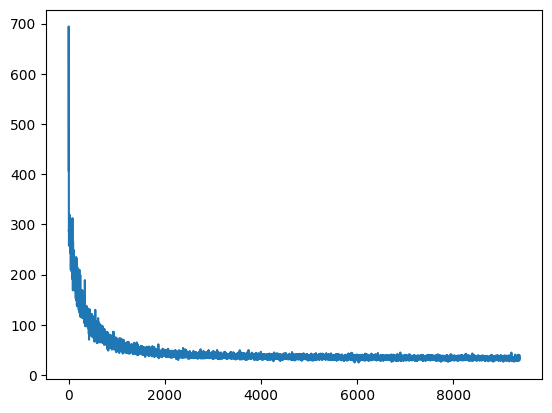

In [16]:
sigmas = torch.tensor(np.exp(np.linspace(np.log(1), np.log(0.01), 10))).float()

refine_net = NoiseConditionalScoreNetwork()

loss_history = train_ncsn(model=refine_net,
                          train_loader=mnist_dataloader,
                          n_epochs=10,
                          lr=1e-3,
                          sigmas=sigmas,
                          use_cuda=USE_CUDA)

In [ ]:
torch.save(refine_net.state_dict(), 'refine_net.pth')

# Visualization

In [ ]:
sigmas = torch.tensor(np.exp(np.linspace(np.log(1), np.log(0.01), 10))).float()

refine_net = NoiseConditionalScoreNetwork()
refine_net.load_state_dict(torch.load('refine_net.pth'))
refine_net.cuda()

In [ ]:
refine_net.eval()
samples, history = refine_net.sample(n_samples=10, n_steps=100, sigmas=sigmas, save_history=True)

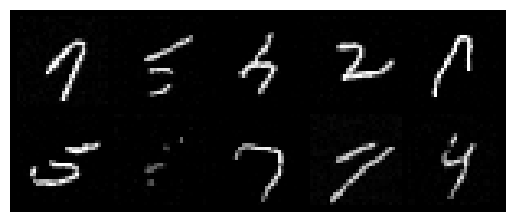

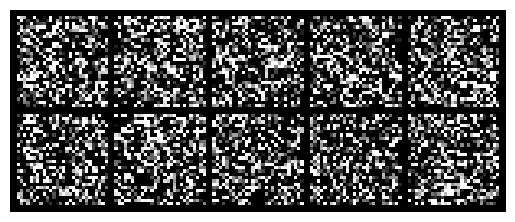

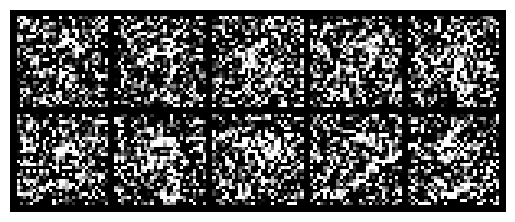

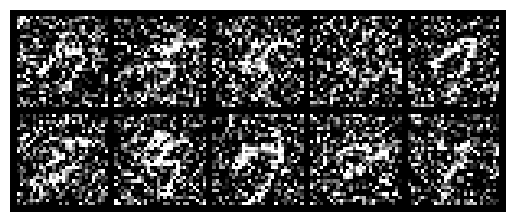

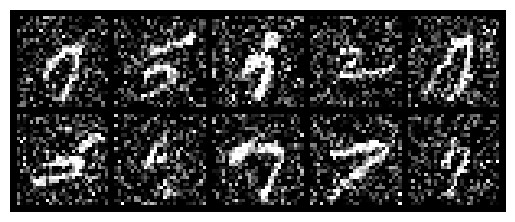

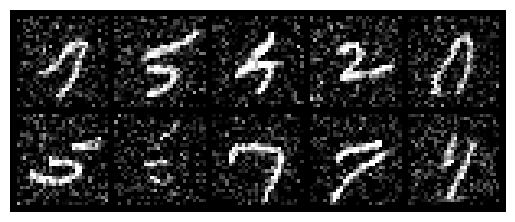

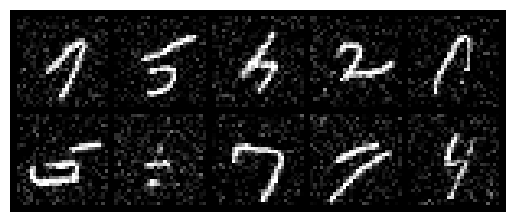

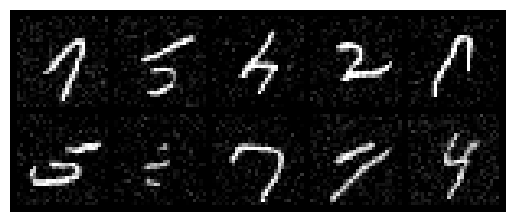

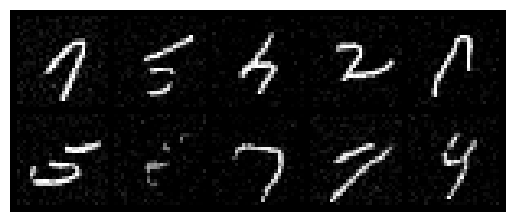

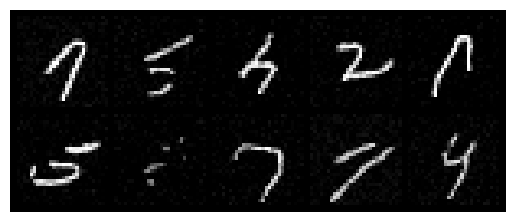

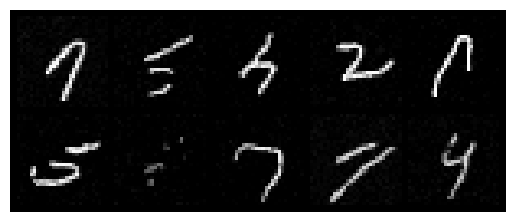

In [ ]:
from torchvision.utils import make_grid

grid_samples = make_grid(samples, nrow=5)

grid_img = grid_samples.permute(1, 2, 0).clip(0, 1)
#plt.figure(figsize=(6, 6))
plt.imshow(grid_img, cmap='Greys')
plt.axis("off")
plt.show()

for step in range(len(history)):
  grid_samples = make_grid(history[step], nrow=5)

  grid_img = grid_samples.permute(1, 2, 0).clip(0, 1)
  #plt.figure(figsize=(6, 6))
  plt.imshow(grid_img, cmap='Greys')
  plt.axis("off")
  plt.show()

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()